# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0  # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 45, 20
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging
# h  = 0.5*(L/NX + H/NY)


# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.2*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---

bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}



# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---
mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
rigid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = mesh.edge_bitset('ghost')
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {mesh.edge_bitset('ghost').cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of pos ghost edges: {mesh.edge_bitset('ghost_pos').cardinality()}")
print(f"Number of neg ghost edges: {mesh.edge_bitset('ghost_neg').cardinality()}")
print(f"Number of ghost edges (both): {mesh.edge_bitset('ghost_both').cardinality()}")


=== DofHandler (CG) ===
        ux: 5445 DOFs @ offset 0
        uy: 5445 DOFs @ offset 9
         p: 1400 DOFs @ offset 18
  total : 12290
Number of interface edges: 28
Number of ghost edges: 54
Number of cut elements: 28
Number of pos ghost edges: 32
Number of neg ghost edges: 20
Number of ghost edges (both): 2


In [5]:
dof_handler.tag_dof_by_locator('p_pin', 'p',
    locator=lambda x,y: np.isclose(x, 0) and np.isclose(y, 0),
    find_first=True)
bcs.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x,y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'p_pin', lambda x,y: 0.0))

# Tag velocity DOFs inside the cylinder (same tag name for both fields is OK)
dof_handler.tag_dofs_from_element_bitset("inactive", "ux", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "uy", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p", "inside", strict=True)

bcs.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('ux', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('uy', 'dirichlet', 'inactive', lambda x, y: 0.0))
bcs_homog.append(BoundaryCondition('p', 'dirichlet', 'inactive', lambda x, y: 0.0))

In [6]:
for name, bitset in mesh._edge_bitsets.items():
    print(f"Edge bitset '{name}': {bitset.cardinality()}")

Edge bitset 'ghost_both': 2
Edge bitset 'ghost_neg': 20
Edge bitset 'ghost_pos': 32
Edge bitset 'interface': 28
Edge bitset 'ghost': 54
Edge bitset 'inlet': 27
Edge bitset 'outlet': 27
Edge bitset 'walls': 98


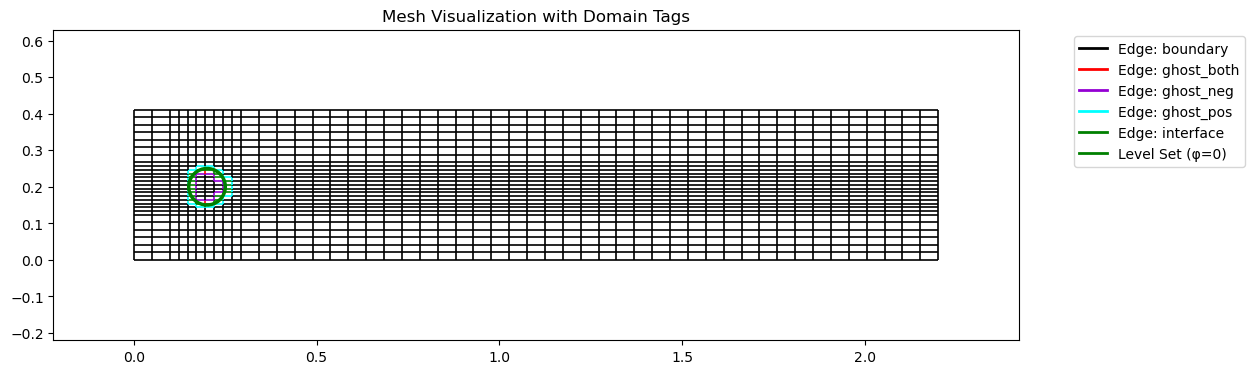

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [7]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [8]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.25)
theta = Constant(0.5) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


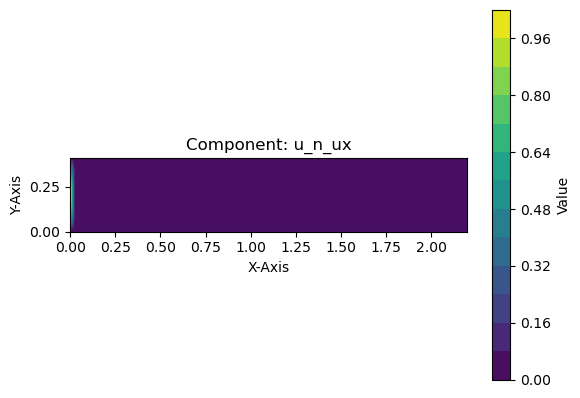

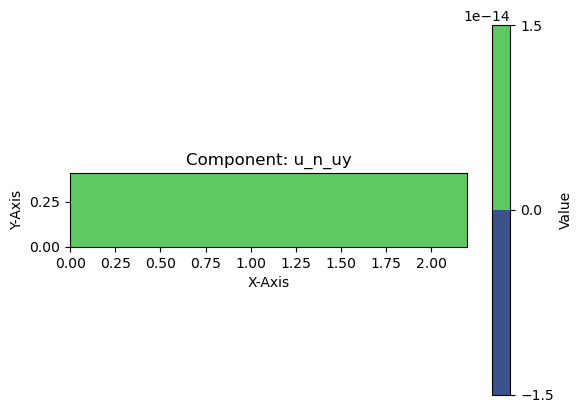

In [9]:
u_n.plot()

In [10]:
print(len(dof_handler.get_dirichlet_data(bcs)))

609


In [11]:
len(dof_handler.get_dirichlet_data(bcs))

609

In [12]:
from pycutfem.ufl.expressions import Derivative, FacetNormal, restrict
from pycutfem.core.geometry import hansbo_cut_ratio
from pycutfem.ufl.expressions import ElementWiseConstant

n = FacetNormal()                    # vector expression (n_x, n_y)
n_f = FacetNormal()                  # vector expression (n_x, n_y) on the fluid side

def _dn(expr):
    """Normal derivative  n·∇expr  on an (interior) edge."""
    return n[0] * Derivative(expr, 1, 0) + n[1] * Derivative(expr, 0, 1)
    # return dot(grad(expr), n)

def grad_inner(u, v):
    """⟨∂ₙu, ∂ₙv⟩  (scalar or 2‑D vector)."""
    if getattr(u, "num_components", 1) == 1:      # scalar
        return _dn(u) * _dn(v)

    if u.num_components == v.num_components == 2: # vector
        return _dn(u[0]) * _dn(v[0]) + _dn(u[1]) * _dn(v[1])

    raise ValueError("grad_inner supports only scalars or 2‑D vectors.")
ghost_edges_used = mesh.edge_bitset('ghost_pos') | mesh.edge_bitset('interface')
dx_phys  = dx(defined_on=physical_domain, 
              level_set=level_set,            # the cylinder level set
              metadata   = {"q": 7, "side": "+"} # integrate only φ>0 (positive side)
    )
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set, metadata={"q":9})   # interior surface
dG       = dGhost(defined_on=ghost_edges_used, level_set=level_set,metadata={"q":6})  # ghost surface

cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(20.0 * poly_order**2)      # Nitsche penalty (tweak)
# 1) Hansbo factor — this is a *numpy array*, one value per element
beta0_val  = 20.0 * poly_order**2
theta_min  = 1.0e-3
hansbo_plus = hansbo_cut_ratio(mesh, level_set, side='+')    # -> np.ndarray, shape (n_elem,)
beta_hansbo_arr = beta0_val / np.clip(hansbo_plus, theta_min, 1.0)

# Wrap only the array part in ElementWiseConstant
β_h = ElementWiseConstant(beta_hansbo_arr)  # OK: per-element scalar

# 2) Symbolic augmentation factor (stays symbolic because of CellDiameter())
augment = mu_const / cell_h + rho_const * cell_h / dt   # scalar expression

# 3) Final penalty (symbolic EWC × expression)
β = β_h * augment

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)

# def sigma_dot_n(u_vec, p_scal):
#     """
#     Expanded form of (σ(u, p) · n) without using the '@' operator.

#         σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
#     """
#     # first term: μ (∇u)·n
#     a = dot(grad(u_vec), n)
#     # second term: μ (∇uᵀ)·n
#     b = dot(grad(u_vec).T, n)
#     # combine and subtract pressure part
#     return mu * (a + b) - p_scal * n         # vector of size 2

def sigma_dot_n_v(u_vec, p_scal,v_test,n):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v,n_f)           # consistency
    - sigma_dot_n_v(v, q, du,n_f)           # symmetry
    # + beta_N * mu / cell_h * dot(du, v)     # penalty
    + β  * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v,n_f)
    - sigma_dot_n_v(v, q, u_k,n_f)
    # + beta_N * mu / cell_h * dot(u_k, v)
    + β  * dot(u_k, v)  
) * dΓ

# volume ------------------------------------------------------------
# a_vol = restrict(( rho*dot(du,v)/dt
#           + theta*rho*dot(dot(grad(u_k), du), v)
#           + theta*rho*dot(dot(grad(du), u_k), v)
#           + theta*mu*inner(grad(du), grad(v))
#           - dp*div(v) + q*div(du) ),physical_domain) * dx_phys

# r_vol = restrict(( rho*dot(u_k-u_n, v)/dt
#           + theta*rho*dot(dot(grad(u_k), u_k), v)
#           + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
#           + theta*mu*inner(grad(u_k), grad(v))
#           + (1-theta)*mu*inner(grad(u_n), grad(v))
#           - p_k*div(v) + q*div(u_k) ),physical_domain) * dx_phys
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + theta*mu*inner(grad(du), grad(v))
          - dp*div(v) + q*div(du) ) * dx_phys

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + theta*mu*inner(grad(u_k), grad(v))
          + (1-theta)*mu*inner(grad(u_n), grad(v))
          - p_k*div(v) + q*div(u_k) ) * dx_phys
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
penalty_val = 20
penalty_grad = 0.1
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad= Constant(penalty_grad * poly_order**2)
gamma_p  = Constant(penalty_val * poly_order**1)
gamma_p_grad = Constant(penalty_grad * poly_order**1)

stab = ( gamma_v  / cell_h   * dot(jump(u_k), jump(v))
       + gamma_v_grad * cell_h   * grad_inner(jump(u_k), jump(v))
       + gamma_p  / cell_h   * jump(p_k) * jump(q)  # Note: use * for scalars, see issue 2
       + gamma_p_grad * cell_h   * grad_inner(jump(p_k), jump(q)) ) * dG

stab_lin  = (( gamma_v  / cell_h   * dot(jump(du),  jump(v)) +
             gamma_v_grad * cell_h   * grad_inner(jump(du),  jump(v))) 
           + ( gamma_p  / cell_h   * jump(dp) *  jump(q)
            + gamma_p_grad * cell_h   * grad_inner(jump(dp),  jump(q)))  ) * dG
# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int + stab
# residual_form  = dot(  Constant(np.array([0.0, 0.0]),dim=1), v) * dx
# jacobian_form  = stab_lin
# residual_form  = stab





In [13]:
# !rm ~/.cache/pycutfem_jit/*

In [14]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [ ]:
from pycutfem.io.vtk import export_vtk
from pycutfem.ufl.compilers import FormCompiler
from pycutfem.ufl.forms import Equation, assemble_form
from pycutfem.fem import transform
output_dir = "turek_results"
os.makedirs(output_dir, exist_ok=True)
step_counter = 0
histories = {}  # Store histories for CD, CL, Δp
# --- Traction helper on Γ: (σ(u,p)·n)·v_dir  -------------------------------
# Uses the same σ as in your Nitsche terms: μ(∇u + ∇uᵀ) - p I
def traction_dot_dir(u_vec, p_scal, v_dir):
    # n is provided by the interface/boundary assembler via FacetNormal()
    a = dot(grad(u_vec),   n)      # (∇u)·n
    b = dot(grad(u_vec).T, n)      # (∇uᵀ)·n
    t = mu*(a + b) - p_scal*n      # σ(u,p)·n   (vector in ℝ²)
    return dot(t, v_dir)           # scalar: (σ·n)·e_x or (σ·n)·e_y


def save_solution(funcs):
    """Export + compute CD, CL, Δp (Turek)."""
    global step_counter

    u_k_func = funcs[0]
    p_k_func = funcs[1]

    # ------------------ VTK output (as you already have) --------------------
    filename = os.path.join(output_dir, f"solution_{step_counter:04d}.vtu")
    export_vtk(
        filename=filename,
        mesh=mesh,
        dof_handler=dof_handler,
        functions={"velocity": u_k_func, "pressure": p_k_func}
    )

    # ------------------ Interface integrals for Drag & Lift -----------------
    # High-order quadrature helps here (Q2 velocity): use q≈11–13
    dΓ = dInterface(defined_on=cut_domain, level_set=level_set, metadata={"q": 11})

    e_x = Constant(np.array([1.0, 0.0]), dim =1)
    e_y = Constant(np.array([0.0, 1.0]), dim =1)

    # traction on the *fluid* side, then flip the sign to get the force on the cylinder
    integrand_drag = -traction_dot_dir(u_k_func, p_k_func, e_x)   # scalar
    integrand_lift = -traction_dot_dir(u_k_func, p_k_func, e_y)   # scalar

    I_drag = integrand_drag * dΓ
    I_lift = integrand_lift * dΓ

    # Assemble the two scalar functionals using the compiler “hooks”
    hooks = {
        I_drag.integrand: {"name": "FD"},
        I_lift.integrand: {"name": "FL"},
    }
    drag_hook = {I_drag.integrand: {"name": "FD"}}
    lift_hook = {I_lift.integrand: {"name": "FL"}}

    res_Fd = assemble_form(I_drag == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=drag_hook, backend="python")
    res_Fl = assemble_form(I_lift == Constant(0.0) * dx, 
                           dof_handler=dof_handler, bcs=[],
                           assembler_hooks=lift_hook, backend="python")

    F_D = float(res_Fd["FD"])
    F_L = float(res_Fl["FL"])

    # Dimensionless coefficients (DFG definition)
    coeff = 2.0 / (rho * (U_mean**2) * D)
    C_D = coeff * F_D
    C_L = coeff * F_L

    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    # ------------------ Pressure difference Δp = p(A) - p(B) ----------------
    def eval_scalar_at_point(f_scalar, x, y):
        """
        Robustly evaluates a scalar field at a point (x,y),
        ensuring the point is in the physical domain.
        """
        xy = np.array([x, y])

        # 1. First, check if the point is in the physical domain.
        if level_set(xy) < 0:
            # print(f"Warning: Point ({x},{y}) is in the fictitious domain (phi < 0). Returning NaN.")
            return np.nan

        # 2. Find the element that contains the point.
        eid_found = None
        for e in mesh.elements_list:
            # Skip elements that are fully inside the cylinder
            if getattr(e, "tag", None) == "inside":
                continue

            # Check if the point is geometrically within the element's bounding box first for efficiency
            v_coords = mesh.nodes_x_y_pos[list(e.corner_nodes)]
            if not (v_coords[:, 0].min() <= x <= v_coords[:, 0].max() and \
                    v_coords[:, 1].min() <= y <= v_coords[:, 1].max()):
                continue

            # Perform precise inverse mapping
            try:
                xi, eta = transform.inverse_mapping(mesh, e.id, xy)
                if -1e-9 <= xi <= 1 + 1e-9 and -1e-9 <= eta <= 1 + 1e-9:
                    eid_found = e.id
                    break
            except (np.linalg.LinAlgError, ValueError):
                continue # Point is outside this element.
        
        if eid_found is None:
            # print(f"Warning: Point ({x},{y}) could not be located in any physical element. Returning NaN.")
            return np.nan

        # 3. Evaluate the field using basis functions at the found reference coords.
        phi = mixed_element.basis(f_scalar.field_name, xi, eta)
        gdofs = dof_handler.get_elemental_dofs(eid_found)
        vals = f_scalar.get_nodal_values(gdofs)
        return float(phi @ vals)

    # Evaluate pressure slightly away from the cylinder boundary for stability.
    # Cylinder is at (0.2, 0.2) with radius 0.05.
    pA = eval_scalar_at_point(p_k_func, c_x - D/2 - 0.01, c_y) # Front point
    pB = eval_scalar_at_point(p_k_func, c_x + D/2 + 0.01, c_y) # Rear point
    dp = pA - pB

    # ------------------ Log / store ----------------------------------------
    print(f"[step {step_counter:4d}]  FD={F_D:.6e}  FL={F_L:.6e}  "
          f"CD={C_D:.6f}  CL={C_L:.6f}  Δp={dp:.6f}")
    if step_counter % 2 == 0:
        u_k_func.plot(field = 'ux',
                      title=f"Velocity Ux at step {step_counter}",
                      xlabel='X-Axis', ylabel='Y-Axis',
                      levels=100, cmap='jet',
                      mask = fluid_domain,)

    # (Optional) append to global histories for later plotting
    histories.setdefault("cd", []).append(C_D)
    histories.setdefault("cl", []).append(C_L)
    histories.setdefault("dp", []).append(dp)


    step_counter += 1



JIT cache miss → compiling _pycutfem_kernel_82890c69dca1ccf40fdc408e0e9a3b4af268cccdfde46156353cbe5a36e77f92.py
--------------------------------------------------------------------------------
Precomputing geometric factors with quad_order=7...
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Precomputing cut volume factors for 1323 elements with qdeg=7 and side='+'
--------------------------------------------------------------------------------
points shape: (42, 2), weights shape: (42,)
Found 28 valid cut elements for cut volume.
JIT cache miss → compiling _pycutfem_kernel_4be7a6c229cb6f9fed3d57a643d55a2cf1665277e8dc3ae94395cb9b78213fa5.py
--------------------------------------------------------------------------------
Precomputing interface factors for 1323 cut elements with qdeg=9...
--------------------------------------------------------------------------------
JIT cac

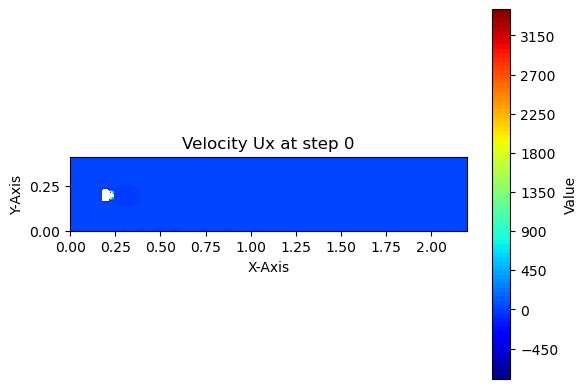

        Newton 1: |R|_∞ = 2.39e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.81e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.12e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 9.92e-08
    Time step 2: ΔU = 4.19e+02
Solution exported to turek_results/solution_0001.vtu
[step    1]  FD=1.625683e-02  FL=3.783704e-04  CD=0.325137  CL=0.007567  Δp=-0.187189
        Newton 1: |R|_∞ = 1.74e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.91e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.23e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 1.13e-06
        Armijo search accepted α = 1.00e+00
        Newton 5: |R|_∞ = 5.69e-10
    Time step 3: ΔU = 2.94e+02
Solution exported to turek_results/solution_0002.vtu
[step    2]  FD=3.473177e-02  FL=-7.152514e-05  CD=0.694635  CL=-0.001431  Δp=-0.339731
Plotting component: 'ux'


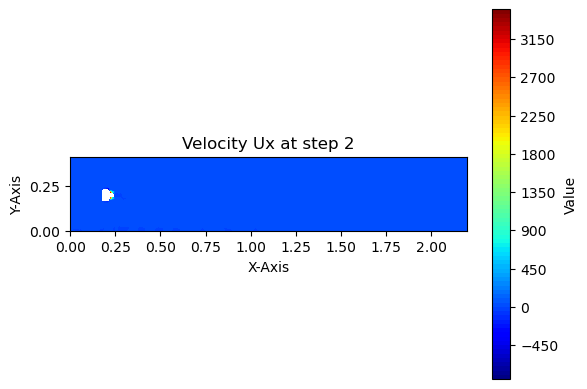

        Newton 1: |R|_∞ = 1.23e-03
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.27e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.53e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 5.24e-07
    Time step 4: ΔU = 8.90e+02
Solution exported to turek_results/solution_0003.vtu
[step    3]  FD=2.376890e-02  FL=-1.096908e-03  CD=0.475378  CL=-0.021938  Δp=-0.275966
        Newton 1: |R|_∞ = 7.89e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.35e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.06e-05
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 6.11e-07
    Time step 5: ΔU = 1.94e+02
Solution exported to turek_results/solution_0004.vtu
[step    4]  FD=2.271546e-02  FL=-9.464920e-04  CD=0.454309  CL=-0.018930  Δp=-0.283158
Plotting component: 'ux'


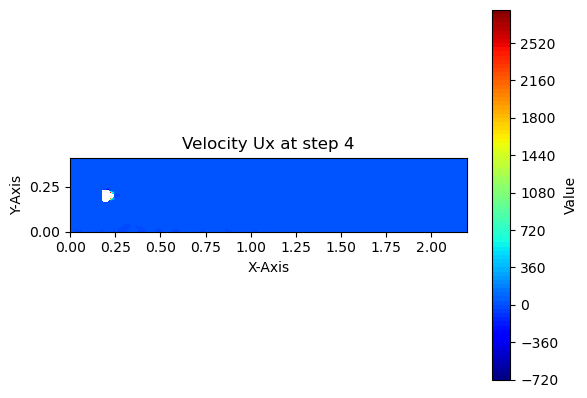

        Newton 1: |R|_∞ = 5.39e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.22e-04
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.76e-06
        Armijo search accepted α = 1.00e+00
        Newton 4: |R|_∞ = 2.73e-09
    Time step 6: ΔU = 6.61e+02
Solution exported to turek_results/solution_0005.vtu
[step    5]  FD=2.055216e-02  FL=3.027969e-05  CD=0.411043  CL=0.000606  Δp=-0.239908
        Newton 1: |R|_∞ = 5.95e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.83e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.76e-07
    Time step 7: ΔU = 1.40e+02
Solution exported to turek_results/solution_0006.vtu
[step    6]  FD=1.749007e-02  FL=7.305703e-04  CD=0.349801  CL=0.014611  Δp=-0.219074
Plotting component: 'ux'


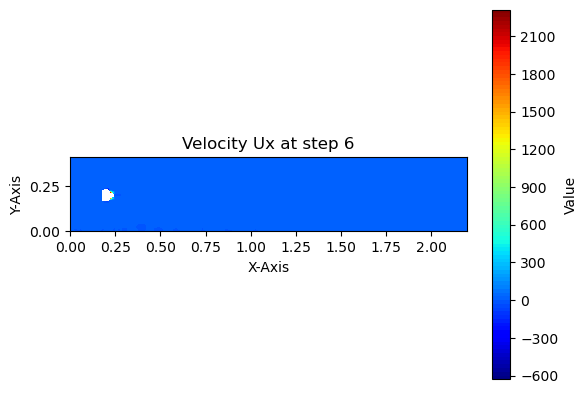

        Newton 1: |R|_∞ = 5.71e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.66e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.70e-07
    Time step 8: ΔU = 7.28e+02
Solution exported to turek_results/solution_0007.vtu
[step    7]  FD=1.606681e-02  FL=5.434485e-04  CD=0.321336  CL=0.010869  Δp=-0.204194
        Newton 1: |R|_∞ = 5.53e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.89e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.66e-07
    Time step 9: ΔU = 1.49e+02
Solution exported to turek_results/solution_0008.vtu
[step    8]  FD=1.399434e-02  FL=4.332724e-04  CD=0.279887  CL=0.008665  Δp=-0.181360
Plotting component: 'ux'


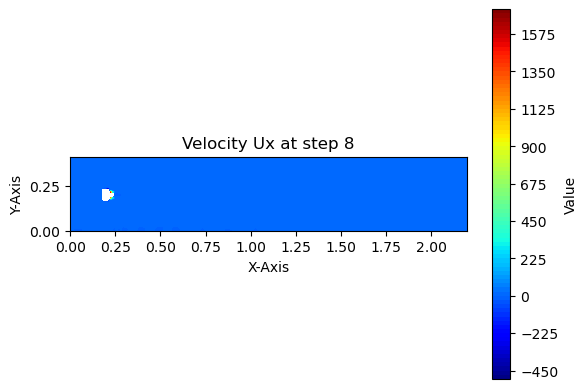

        Newton 1: |R|_∞ = 4.93e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.75e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 7.58e-08
    Time step 10: ΔU = 5.45e+02
Solution exported to turek_results/solution_0009.vtu
[step    9]  FD=1.240426e-02  FL=1.216080e-04  CD=0.248085  CL=0.002432  Δp=-0.169076
        Newton 1: |R|_∞ = 4.21e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.41e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.35e-08
    Time step 11: ΔU = 1.59e+02
Solution exported to turek_results/solution_0010.vtu
[step   10]  FD=1.154610e-02  FL=2.443407e-04  CD=0.230922  CL=0.004887  Δp=-0.150488
Plotting component: 'ux'


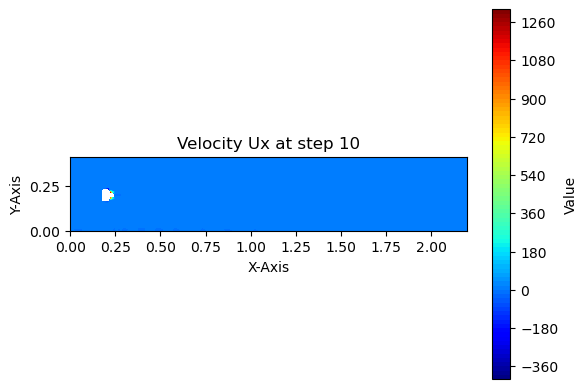

        Newton 1: |R|_∞ = 3.41e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.28e-05
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.23e-08
    Time step 12: ΔU = 4.32e+02
Solution exported to turek_results/solution_0011.vtu
[step   11]  FD=9.840565e-03  FL=-2.568105e-06  CD=0.196811  CL=-0.000051  Δp=-0.139965
        Newton 1: |R|_∞ = 2.68e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.95e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 8.40e-09
    Time step 13: ΔU = 1.61e+02
Solution exported to turek_results/solution_0012.vtu
[step   12]  FD=9.629213e-03  FL=1.694854e-04  CD=0.192584  CL=0.003390  Δp=-0.127183
Plotting component: 'ux'


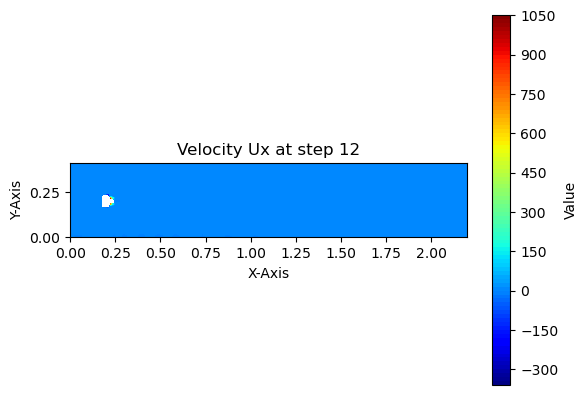

        Newton 1: |R|_∞ = 2.24e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 9.82e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.38e-08
    Time step 14: ΔU = 3.66e+02
Solution exported to turek_results/solution_0013.vtu
[step   13]  FD=8.061215e-03  FL=-4.156601e-05  CD=0.161224  CL=-0.000831  Δp=-0.118125
        Newton 1: |R|_∞ = 1.89e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 6.02e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.07e-09
    Time step 15: ΔU = 1.75e+02
Solution exported to turek_results/solution_0014.vtu
[step   14]  FD=8.109564e-03  FL=1.115261e-04  CD=0.162191  CL=0.002231  Δp=-0.109600
Plotting component: 'ux'


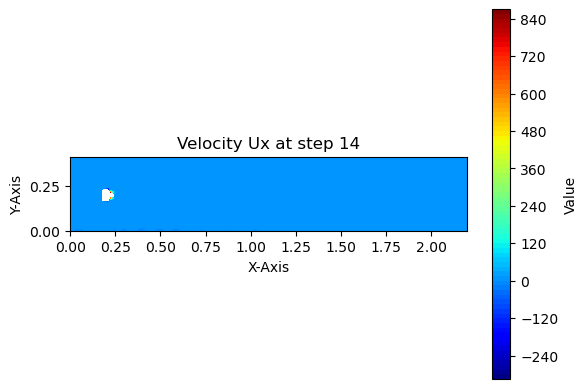

        Newton 1: |R|_∞ = 1.69e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 6.77e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.79e-09
    Time step 16: ΔU = 3.31e+02
Solution exported to turek_results/solution_0015.vtu
[step   15]  FD=6.817467e-03  FL=-5.692776e-05  CD=0.136349  CL=-0.001139  Δp=-0.102070
        Newton 1: |R|_∞ = 1.57e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.97e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.90e-09
    Time step 17: ΔU = 1.94e+02
Solution exported to turek_results/solution_0016.vtu
[step   16]  FD=6.917117e-03  FL=6.621515e-05  CD=0.138342  CL=0.001324  Δp=-0.096359
Plotting component: 'ux'


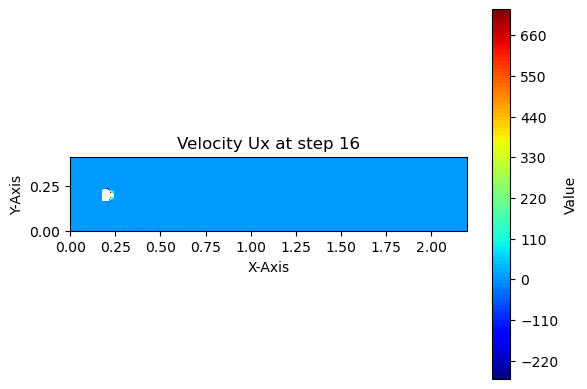

        Newton 1: |R|_∞ = 1.63e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.42e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.15e-09
    Time step 18: ΔU = 3.12e+02
Solution exported to turek_results/solution_0017.vtu
[step   17]  FD=5.925668e-03  FL=-6.778420e-05  CD=0.118513  CL=-0.001356  Δp=-0.090195
        Newton 1: |R|_∞ = 1.63e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.57e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.94e-10
    Time step 19: ΔU = 2.11e+02
Solution exported to turek_results/solution_0018.vtu
[step   18]  FD=5.986675e-03  FL=3.591491e-05  CD=0.119734  CL=0.000718  Δp=-0.086285
Plotting component: 'ux'


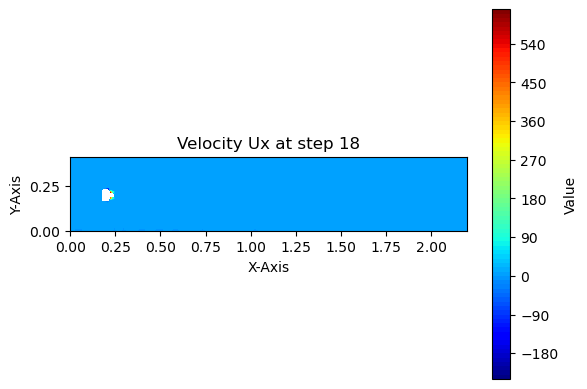

        Newton 1: |R|_∞ = 1.55e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.85e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 1.45e-09
    Time step 20: ΔU = 2.98e+02
Solution exported to turek_results/solution_0019.vtu
[step   19]  FD=5.272882e-03  FL=-8.114138e-05  CD=0.105458  CL=-0.001623  Δp=-0.081348
        Newton 1: |R|_∞ = 1.45e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.58e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 4.41e-10
    Time step 21: ΔU = 2.24e+02
Solution exported to turek_results/solution_0020.vtu
[step   20]  FD=5.276038e-03  FL=1.884859e-05  CD=0.105521  CL=0.000377  Δp=-0.078661
Plotting component: 'ux'


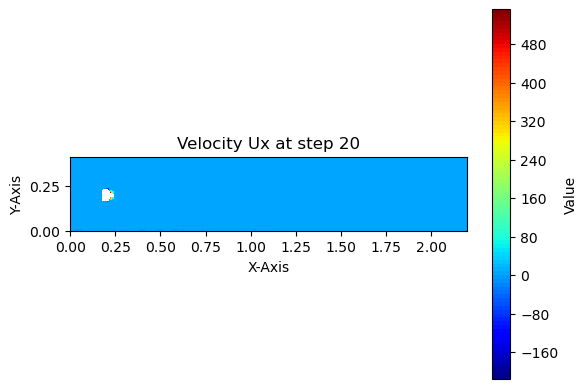

        Newton 1: |R|_∞ = 1.30e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.85e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 6.42e-10
    Time step 22: ΔU = 2.85e+02
Solution exported to turek_results/solution_0021.vtu
[step   21]  FD=4.803692e-03  FL=-9.567884e-05  CD=0.096074  CL=-0.001914  Δp=-0.074902
        Newton 1: |R|_∞ = 1.17e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.94e-07
    Time step 23: ΔU = 2.32e+02
Solution exported to turek_results/solution_0022.vtu
[step   22]  FD=4.763278e-03  FL=9.251582e-06  CD=0.095266  CL=0.000185  Δp=-0.073113
Plotting component: 'ux'


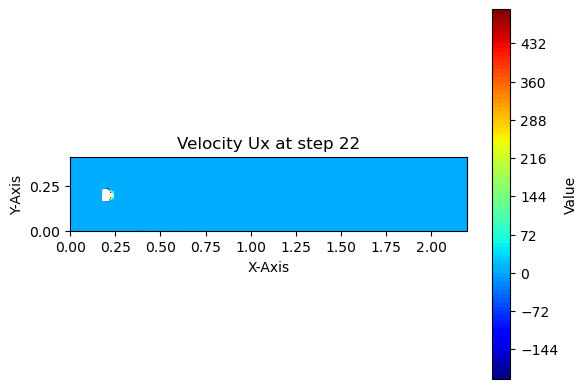

        Newton 1: |R|_∞ = 1.01e-04
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.30e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 3.67e-10
    Time step 24: ΔU = 2.73e+02
Solution exported to turek_results/solution_0023.vtu
[step   23]  FD=4.479977e-03  FL=-1.066020e-04  CD=0.089600  CL=-0.002132  Δp=-0.070436
        Newton 1: |R|_∞ = 8.79e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 7.54e-07
    Time step 25: ΔU = 2.35e+02
Solution exported to turek_results/solution_0024.vtu
[step   24]  FD=4.402995e-03  FL=3.881288e-06  CD=0.088060  CL=0.000078  Δp=-0.069261
Plotting component: 'ux'


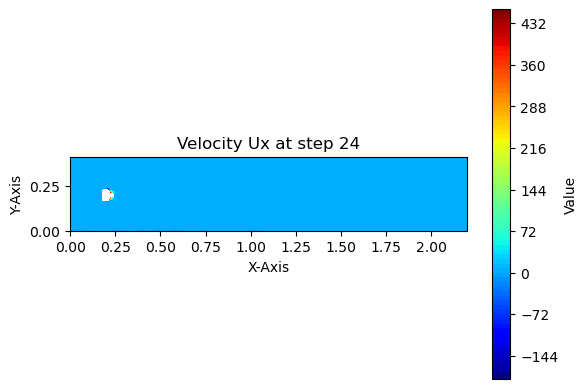

        Newton 1: |R|_∞ = 7.43e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 1.02e-06
        Armijo search accepted α = 1.00e+00
        Newton 3: |R|_∞ = 2.30e-10
    Time step 26: ΔU = 2.65e+02
Solution exported to turek_results/solution_0025.vtu
[step   25]  FD=4.241995e-03  FL=-1.146501e-04  CD=0.084840  CL=-0.002293  Δp=-0.067214
        Newton 1: |R|_∞ = 6.41e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.84e-07
    Time step 27: ΔU = 2.36e+02
Solution exported to turek_results/solution_0026.vtu
[step   26]  FD=4.128510e-03  FL=-1.151047e-06  CD=0.082570  CL=-0.000023  Δp=-0.066290
Plotting component: 'ux'


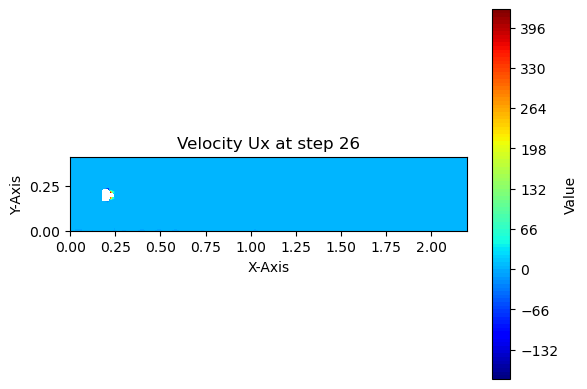

        Newton 1: |R|_∞ = 6.29e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 8.52e-07
    Time step 28: ΔU = 2.59e+02
Solution exported to turek_results/solution_0027.vtu
[step   27]  FD=4.046693e-03  FL=-1.204322e-04  CD=0.080934  CL=-0.002409  Δp=-0.064692
        Newton 1: |R|_∞ = 5.86e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.32e-07
    Time step 29: ΔU = 2.37e+02
Solution exported to turek_results/solution_0028.vtu
[step   28]  FD=3.918387e-03  FL=-5.948908e-06  CD=0.078368  CL=-0.000119  Δp=-0.063918
Plotting component: 'ux'


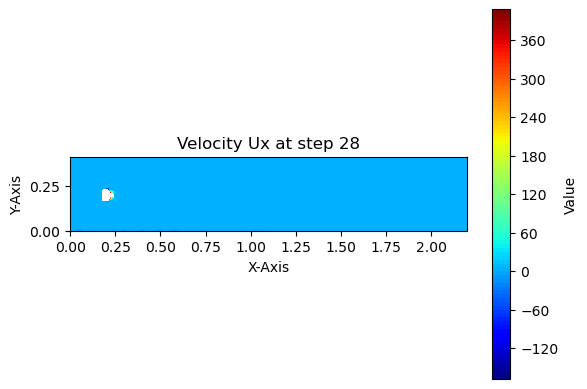

        Newton 1: |R|_∞ = 5.54e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 7.00e-07
    Time step 30: ΔU = 2.56e+02
Solution exported to turek_results/solution_0029.vtu
[step   29]  FD=3.884716e-03  FL=-1.237354e-04  CD=0.077694  CL=-0.002475  Δp=-0.062698
        Newton 1: |R|_∞ = 5.65e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.91e-07
    Time step 31: ΔU = 2.38e+02
Solution exported to turek_results/solution_0030.vtu
[step   30]  FD=3.759458e-03  FL=-1.087276e-05  CD=0.075189  CL=-0.000217  Δp=-0.062028
Plotting component: 'ux'


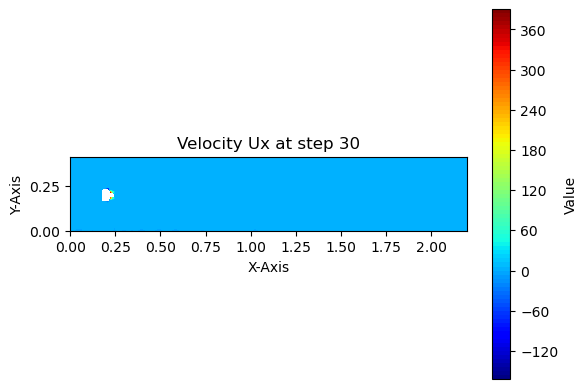

        Newton 1: |R|_∞ = 5.66e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.97e-07
    Time step 32: ΔU = 2.54e+02
Solution exported to turek_results/solution_0031.vtu
[step   31]  FD=3.748898e-03  FL=-1.258066e-04  CD=0.074978  CL=-0.002516  Δp=-0.061116
        Newton 1: |R|_∞ = 5.57e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.62e-07
    Time step 33: ΔU = 2.40e+02
Solution exported to turek_results/solution_0032.vtu
[step   32]  FD=3.639716e-03  FL=-1.480969e-05  CD=0.072794  CL=-0.000296  Δp=-0.060519
Plotting component: 'ux'


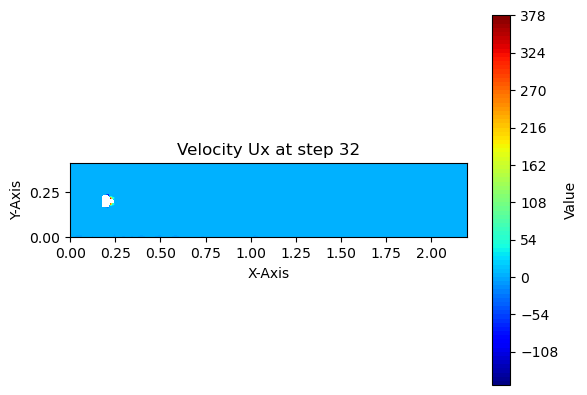

        Newton 1: |R|_∞ = 5.33e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 5.20e-07
    Time step 34: ΔU = 2.53e+02
Solution exported to turek_results/solution_0033.vtu
[step   33]  FD=3.634162e-03  FL=-1.279213e-04  CD=0.072683  CL=-0.002558  Δp=-0.059853
        Newton 1: |R|_∞ = 5.00e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.40e-07
    Time step 35: ΔU = 2.42e+02
Solution exported to turek_results/solution_0034.vtu
[step   34]  FD=3.549527e-03  FL=-1.726589e-05  CD=0.070991  CL=-0.000345  Δp=-0.059310
Plotting component: 'ux'


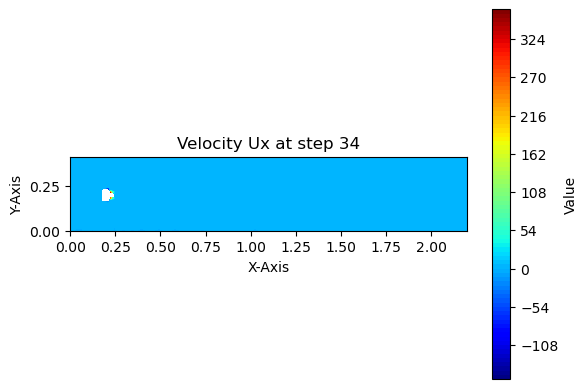

        Newton 1: |R|_∞ = 4.58e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.60e-07
    Time step 36: ΔU = 2.52e+02
Solution exported to turek_results/solution_0035.vtu
[step   35]  FD=3.537488e-03  FL=-1.304260e-04  CD=0.070750  CL=-0.002609  Δp=-0.058840
        Newton 1: |R|_∞ = 4.13e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.21e-07
    Time step 37: ΔU = 2.43e+02
Solution exported to turek_results/solution_0036.vtu
[step   36]  FD=3.481598e-03  FL=-1.845925e-05  CD=0.069632  CL=-0.000369  Δp=-0.058344
Plotting component: 'ux'


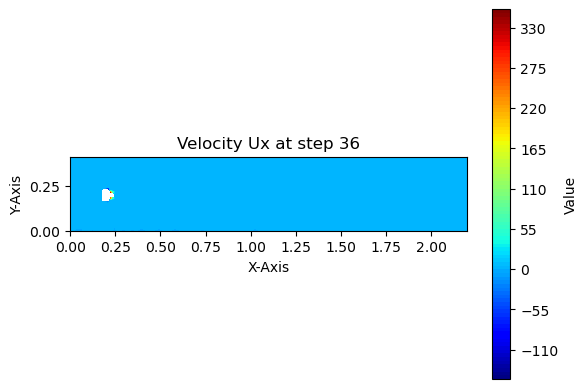

        Newton 1: |R|_∞ = 3.63e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 4.11e-07
    Time step 38: ΔU = 2.51e+02
Solution exported to turek_results/solution_0037.vtu
[step   37]  FD=3.456736e-03  FL=-1.330827e-04  CD=0.069135  CL=-0.002662  Δp=-0.058023
        Newton 1: |R|_∞ = 3.14e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.04e-07
    Time step 39: ΔU = 2.44e+02
Solution exported to turek_results/solution_0038.vtu
[step   38]  FD=3.429800e-03  FL=-1.896764e-05  CD=0.068596  CL=-0.000379  Δp=-0.057576
Plotting component: 'ux'


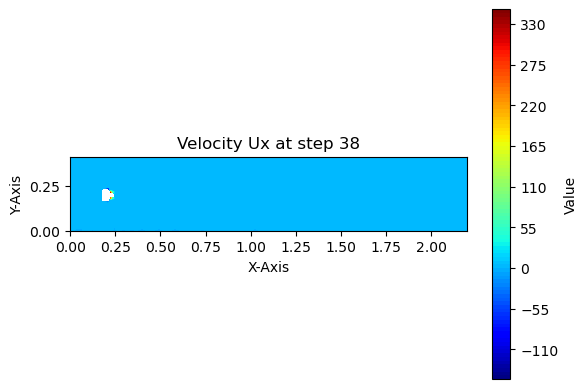

        Newton 1: |R|_∞ = 2.89e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.70e-07
    Time step 40: ΔU = 2.49e+02
Solution exported to turek_results/solution_0039.vtu
[step   39]  FD=3.390383e-03  FL=-1.354268e-04  CD=0.067808  CL=-0.002709  Δp=-0.057362
        Newton 1: |R|_∞ = 2.74e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.87e-07
    Time step 41: ΔU = 2.43e+02
Solution exported to turek_results/solution_0040.vtu
[step   40]  FD=3.389301e-03  FL=-1.939177e-05  CD=0.067786  CL=-0.000388  Δp=-0.056968
Plotting component: 'ux'


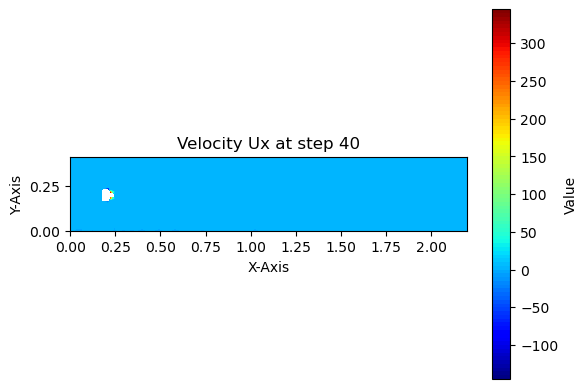

        Newton 1: |R|_∞ = 2.57e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.35e-07
    Time step 42: ΔU = 2.47e+02
Solution exported to turek_results/solution_0041.vtu
[step   41]  FD=3.337003e-03  FL=-1.370773e-04  CD=0.066740  CL=-0.002742  Δp=-0.056823
        Newton 1: |R|_∞ = 2.40e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.70e-07
    Time step 43: ΔU = 2.41e+02
Solution exported to turek_results/solution_0042.vtu
[step   42]  FD=3.356524e-03  FL=-2.011744e-05  CD=0.067130  CL=-0.000402  Δp=-0.056489
Plotting component: 'ux'


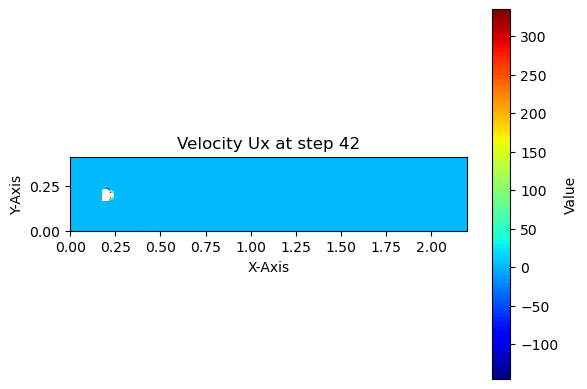

        Newton 1: |R|_∞ = 2.23e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 3.04e-07
    Time step 44: ΔU = 2.44e+02
Solution exported to turek_results/solution_0043.vtu
[step   43]  FD=3.295101e-03  FL=-1.379047e-04  CD=0.065902  CL=-0.002758  Δp=-0.056383
        Newton 1: |R|_∞ = 2.18e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.53e-07
    Time step 45: ΔU = 2.39e+02
Solution exported to turek_results/solution_0044.vtu
[step   44]  FD=3.328979e-03  FL=-2.123544e-05  CD=0.066580  CL=-0.000425  Δp=-0.056113
Plotting component: 'ux'


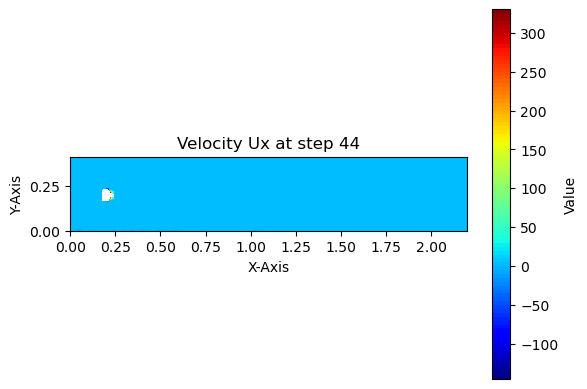

        Newton 1: |R|_∞ = 2.17e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.76e-07
    Time step 46: ΔU = 2.41e+02
Solution exported to turek_results/solution_0045.vtu
[step   45]  FD=3.263138e-03  FL=-1.380372e-04  CD=0.065263  CL=-0.002761  Δp=-0.056024
        Newton 1: |R|_∞ = 2.23e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.36e-07
    Time step 47: ΔU = 2.37e+02
Solution exported to turek_results/solution_0046.vtu
[step   46]  FD=3.305089e-03  FL=-2.260245e-05  CD=0.066102  CL=-0.000452  Δp=-0.055816
Plotting component: 'ux'


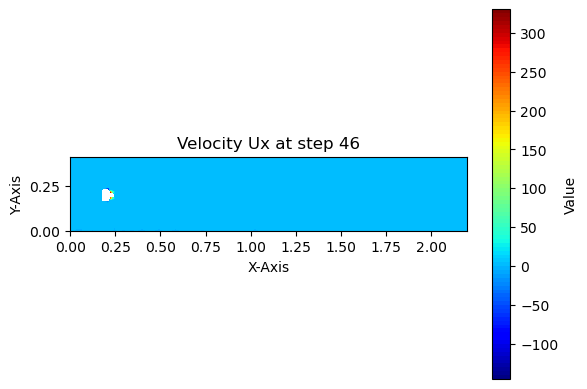

        Newton 1: |R|_∞ = 2.24e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.52e-07
    Time step 48: ΔU = 2.39e+02
Solution exported to turek_results/solution_0047.vtu
[step   47]  FD=3.239475e-03  FL=-1.377577e-04  CD=0.064790  CL=-0.002755  Δp=-0.055732
        Newton 1: |R|_∞ = 2.22e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.20e-07
    Time step 49: ΔU = 2.35e+02
Solution exported to turek_results/solution_0048.vtu
[step   48]  FD=3.283980e-03  FL=-2.397608e-05  CD=0.065680  CL=-0.000480  Δp=-0.055581
Plotting component: 'ux'


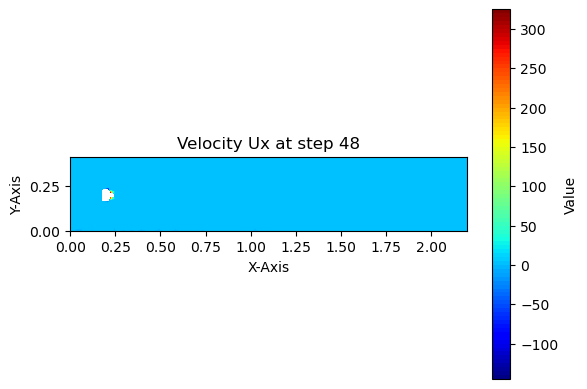

        Newton 1: |R|_∞ = 2.21e-05
        Armijo search accepted α = 1.00e+00
        Newton 2: |R|_∞ = 2.31e-07
    Time step 50: ΔU = 2.36e+02
Solution exported to turek_results/solution_0049.vtu
[step   49]  FD=3.222438e-03  FL=-1.373632e-04  CD=0.064449  CL=-0.002747  Δp=-0.055496


(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.71400002e-05, -4.87226958e-06, -1.35902591e-07]),
 50,
 958.316375592025)

In [16]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters, AdamNewtonSolver
from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")


# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=50 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
    postproc_timeloop_cb=save_solution
)
# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

Text(0, 0.5, 'Δp')

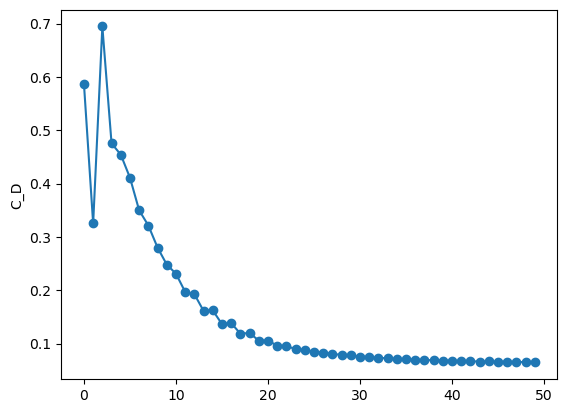

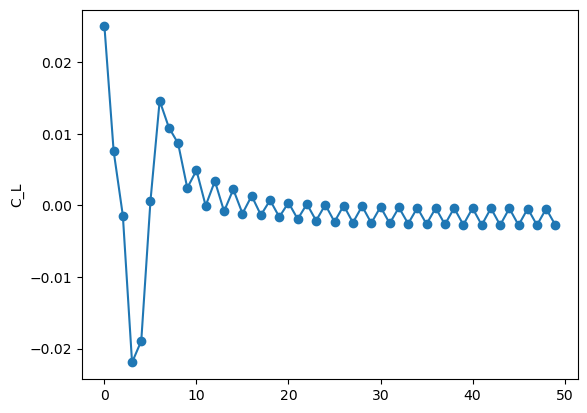

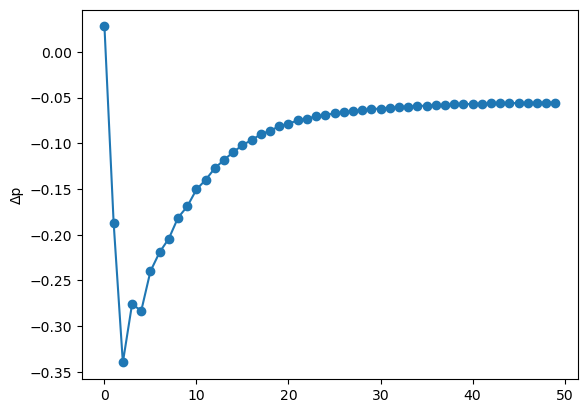

In [18]:
plt.plot(histories["cd"], label="C_D", marker='o')
plt.ylabel('C_D')
plt.figure()
plt.plot(histories["cl"], label="C_L", marker='o')
plt.ylabel('C_L')
plt.figure()
plt.plot(histories["dp"], label="Δp", marker='o')
plt.ylabel('Δp')

Plotting all components of 'u_n' as separate contour plots...


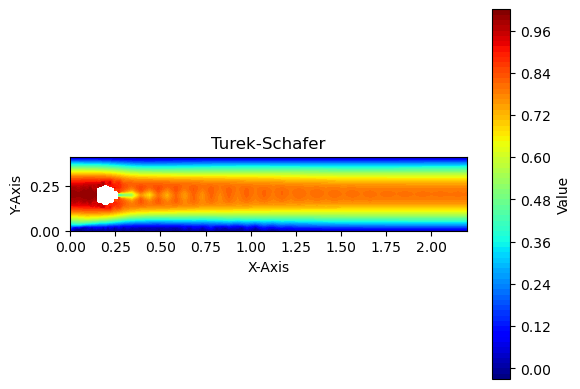

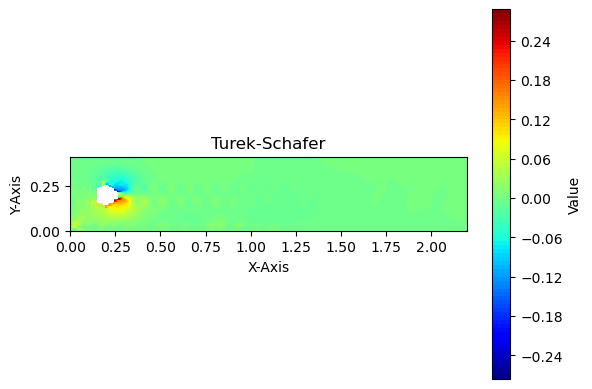

In [25]:


u_n.plot(kind="contour",mask =fluid_domain,
         title="Turek-Schafer",
         xlabel='X-Axis', ylabel='Y-Axis',
         levels=100, cmap='jet')

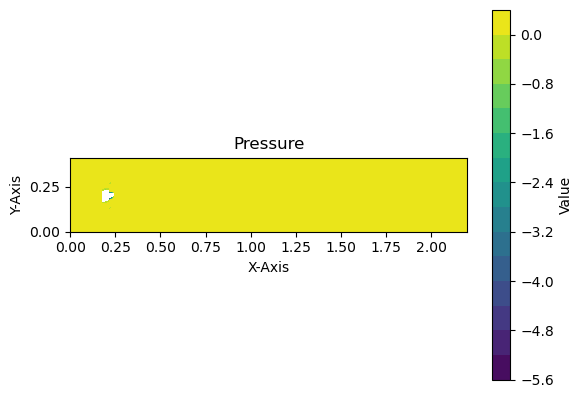

In [20]:
p_n.plot(
         title="Pressure",mask =physical_domain)